# SVM и его ядра
__Суммарное количество баллов: 9__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW07] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании нам предстоит решить задачу SVM при помощи `cvxopt` и применить ее к искуственным данным. Затем аналогичным способом нужно будет решить задачу ядерного SVM и исследовать его поведение для различных ядер и значений их параметров.

In [1]:
import numpy as np
import copy
from cvxopt import spmatrix, matrix, solvers
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_blobs
from sklearn.svm import SVC
import scipy.spatial as sp
solvers.options['show_progress'] = False

In [2]:
def visualize(clf, X, y):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_border = (x_max - x_min) / 20 + 1.0e-3
    x_h = (x_max - x_min + 2 * x_border) / 200
    y_border = (y_max - y_min) / 20 + 1.0e-3
    y_h = (y_max - y_min + 2 * y_border) / 200
    
    cm = plt.cm.Spectral

    xx, yy = np.meshgrid(np.arange(x_min - x_border, x_max + x_border, x_h), np.arange(y_min - y_border, y_max + y_border, y_h))
    mesh = np.c_[xx.ravel(), yy.ravel()]

    z_class = clf.predict(mesh).reshape(xx.shape)

    # Put the result into a color plot
    plt.figure(1, figsize=(8, 8))
    plt.pcolormesh(xx, yy, z_class, cmap=cm, alpha=0.3, shading='gouraud')

    # Plot hyperplane and margin
    z_dist = clf.decision_function(mesh).reshape(xx.shape)
    plt.contour(xx, yy, z_dist, [0.0], colors='black')
    plt.contour(xx, yy, z_dist, [-1.0, 1.0], colors='black', linestyles='dashed')

    # Plot also the training points
    y_pred = clf.predict(X)

    ind_support = []
    ind_correct = []
    ind_incorrect = []
    for i in range(len(y)):
        if i in clf.support:
            ind_support.append(i)
        elif y[i] == y_pred[i]:
            ind_correct.append(i)
        else:
            ind_incorrect.append(i)

    plt.scatter(X[ind_correct, 0], X[ind_correct, 1], c=y[ind_correct], cmap=cm, alpha=1., edgecolor='black', linewidth=.8)
    plt.scatter(X[ind_incorrect, 0], X[ind_incorrect, 1], c=y[ind_incorrect], cmap=cm, alpha=1., marker='*',
               s=50, edgecolor='black', linewidth=.8)
    plt.scatter(X[ind_support, 0], X[ind_support, 1], c=y[ind_support], cmap=cm, alpha=1., edgecolor='yellow', linewidths=1.,
               s=40)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tight_layout()

In [3]:
def generate_dataset(moons=False, dots=1000):
    if moons:
        X, y = make_moons(dots, noise=0.075, random_state=42)
        return X, 2 * y - 1
    X, y = make_blobs(dots, 2, centers=[[0, 0], [-4, 2], [3.5, -2.0], [3.5, 3.5]], random_state=42)
    y = 2 * (y % 2) - 1
    return X, y
    #return make_classification(1000, 2, 2, 0, flip_y=0.001, class_sep=1.2, scale=0.9, random_state=42)

X, y = generate_dataset(True)

### Задание 1 (2 балла)
Для начала реализуем обычный линейный SVM. 

#### Методы
`fit(X, y)` - обучает SVM, решая задачу оптимизации при помощи `cvxopt.solvers.qp`

`decision_function(X)` - возвращает значение решающей функции (т.е. то число, от которого берем знак с целью узнать класс)

#### Поля
`support` - индексы опорных элементов

In [4]:
class OG:
    def __init__(self, C=1, kernel="linear", gamma=0.5, degree=3, coef=0.1):
        self.svm = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=coef)
        
    def fit(self, X, y):
        self.svm.fit(X, y)
        self.support = self.svm.support_
    
    def decision_function(self, X):
        return self.svm.decision_function(X)

    def predict(self, X):
        return np.sign(self.decision_function(X))
    

In [5]:
class LinearSVM:
    def __init__(self, C):
        self.C = C
        self.support = None

    def fit(self, X, y):
        Z = X * y.reshape(-1, 1)
        P = np.dot(Z, Z.T)
        G1 = -np.eye(X.shape[0])
        G2 = np.eye(X.shape[0])
        G = np.vstack((G1, G2))
        q = -np.ones(X.shape[0])
        h1 = np.zeros(X.shape[0])
        h2 = self.C * np.ones(X.shape[0])
        h = np.hstack((h1, h2))
        b = np.zeros(1)
        
        q = matrix(q, tc='d')
        h = matrix(h, tc='d')
        b = matrix(b, tc='d')
        A = matrix(y, tc='d').T
        G = matrix(G, tc='d')
        P = matrix(P, tc='d')
        
        res = solvers.qp(P, q, G, h, A, b)
        
        x = np.array(res['x'])
        self.x = x
        x[x < 1e-8] = 0
        self.w = np.sum(x * Z, axis=0)
        self.support = np.arange(X.shape[0])[x.squeeze() > 0]
        cur = 0
        while cur < len(self.support) and (x[self.support[cur]] > self.C - 1e-6 or  x[self.support[cur]] < 1e-6):
            cur += 1
        if cur == len(self.support):
            cur = 0
                
        self.cur = cur
        self.b = np.dot(X[self.support[cur]], self.w) - y[self.support[cur]]

    def decision_function(self, X):
        return np.dot(X, self.w) - self.b

    def predict(self, X):
        return np.sign(self.decision_function(X))

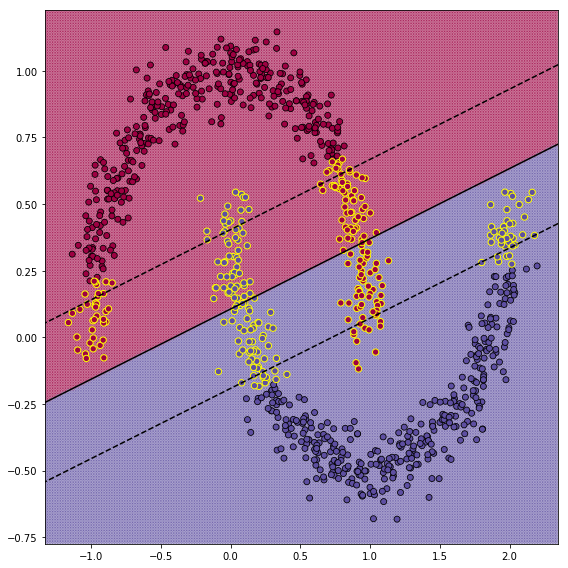

In [6]:
X, y = generate_dataset(True)
svm = LinearSVM(1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

Для теста сравним с реализацией из sklearn

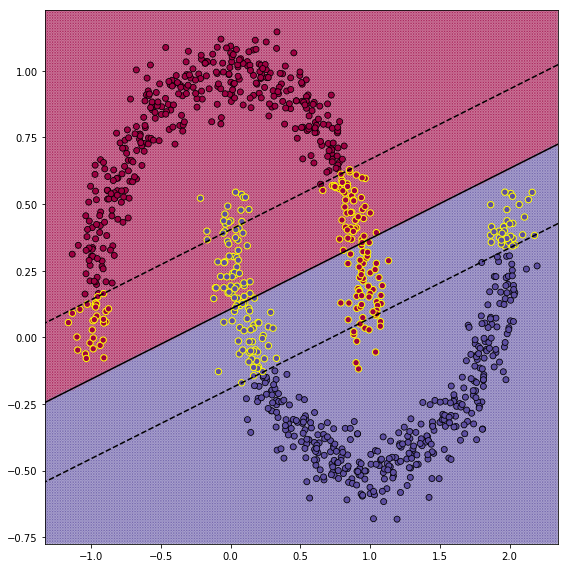

In [7]:
svm = OG(kernel='linear', C=1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

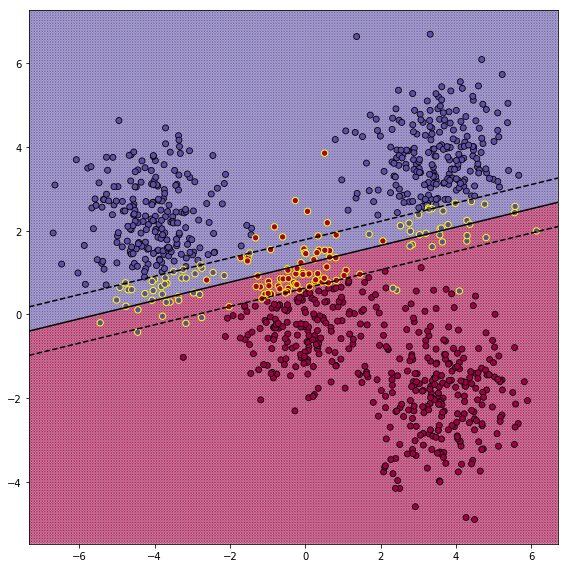

In [8]:
X, y = generate_dataset(False)
svm = LinearSVM(1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

Реализация из sklearn

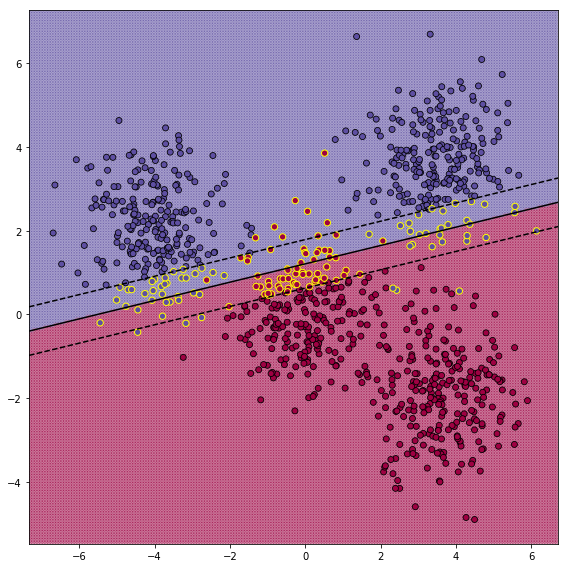

In [9]:
svm = OG(kernel='linear', C=1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

### Задание 2 (2 балла)
Перед реализацией ядерного SVM, реализуем функции, которые строят ядра.

#### Описание
`get_polynomial_kernel(c, power)` - возвращает полиномиальное ядро с заданной константой и степенью

`get_gaussian_kernel(sigma=1.)` - возвращает ядро Гаусса с заданным коэффицинтом сигма

In [10]:
def get_polynomial_kernel(c=1, power=2):
    def kernel(X1, X2):
        return np.power(c + np.dot(X1, X2.T), power)
    return kernel

def get_gaussian_kernel(sigma=1.):
    def kernel(X1, X2):
        if len(X1.shape) == 1:
            X1 = X1.reshape(1, X1.shape[0])
        if len(X2.shape) == 1:
            X2 = X2.reshape(1, X2.shape[0])
        dist = sp.distance_matrix(X1, X2)
        dist = np.power(dist, 2)
        coef = -1 / 2 / sigma / sigma
        return np.exp(dist * coef)

    return kernel

### Задание 3 (2 балла)
Теперь перейдем к реализации самого kernel SVM.

#### Описание
`fit(X, y)` - обучает kernel SVM, решая задачу оптимизации при помощи `cvxopt.solvers.qp`

`decision_function(X)` - возвращает значение решающей функции (т.е. то число, от которого берем знак с целью узнать класс)

#### Конструктор
`kernel` - ядро-функция

In [11]:
class KernelSVM:
    def __init__(self, C, kernel, eps=1e-6):
        self.C = C
        self.kernel= kernel
        self.eps = eps
        self.support = None
        self.xs = None
        self.m = None
        
    def fit(self, X, y):
        
        P = self.kernel(X, X) * np.outer(y, y)
        G1 = -np.eye(X.shape[0])
        G2 = np.eye(X.shape[0])
        G = np.vstack((G1, G2))
        q = -np.ones(X.shape[0])
        h1 = np.zeros(X.shape[0])
        h2 = self.C * np.ones(X.shape[0])
        h = np.hstack((h1, h2))
        b = np.zeros(1)
        
        q = matrix(q, tc='d')
        h = matrix(h, tc='d')
        b = matrix(b, tc='d')
        A = matrix(y, tc='d').T
        G = matrix(G, tc='d')
        P = matrix(P, tc='d')
        
        res = solvers.qp(P, q, G, h, A, b)
        
        x = np.array(res['x'])
        x[x < self.eps] = 0
        
        self.support = np.arange(X.shape[0])[x.squeeze() > 0]
        self.xs = X[self.support]
        self.m = y[self.support].reshape(-1, 1) * x[self.support]
        cur = 0
        while cur < len(self.support) and (x[self.support[cur]] > self.C - self.eps or  x[self.support[cur]] < self.eps):
            cur += 1
        if cur == len(self.support):
            cur = 0
                
        self.b = self.prod(X[self.support[cur]]) - y[self.support[cur]]
       
    
    def prod(self, x):
        if len(x.shape) == 1:
            x = x.reshape(1, x.shape[0])
        return np.sum(self.kernel(self.xs, x) * self.m, axis=0)

    def decision_function(self, X):
        return self.prod(X) - self.b

    def predict(self, X):
        return np.sign(self.decision_function(X))

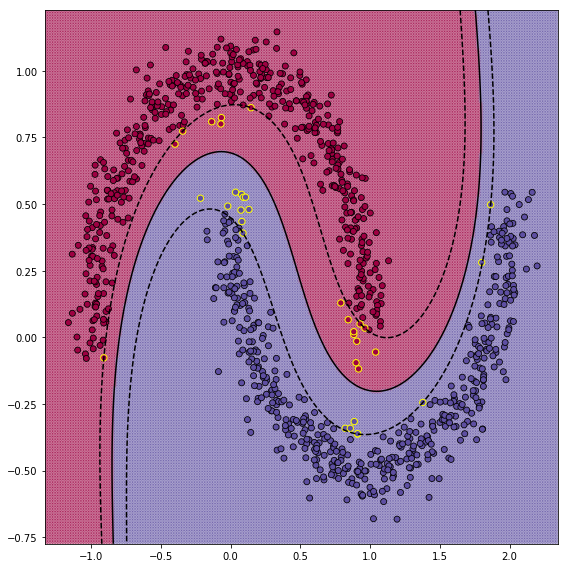

In [12]:
X, y = generate_dataset(True)
svm = KernelSVM(1, kernel=get_polynomial_kernel(1, 3))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

Реализация из sklearn

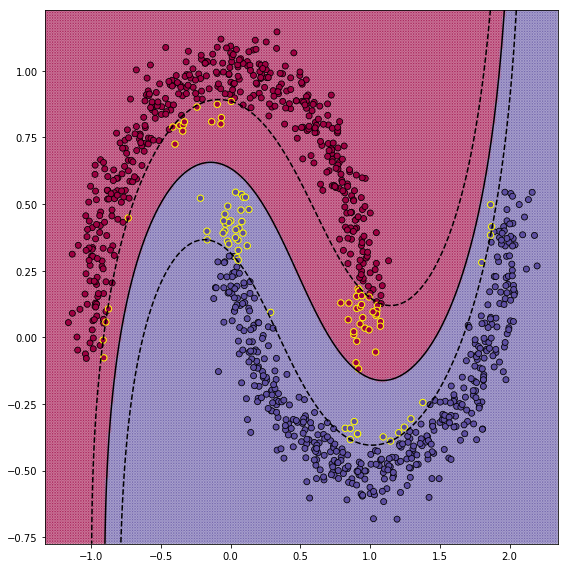

In [13]:
svm = OG(1, kernel="poly", degree=3, coef=1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

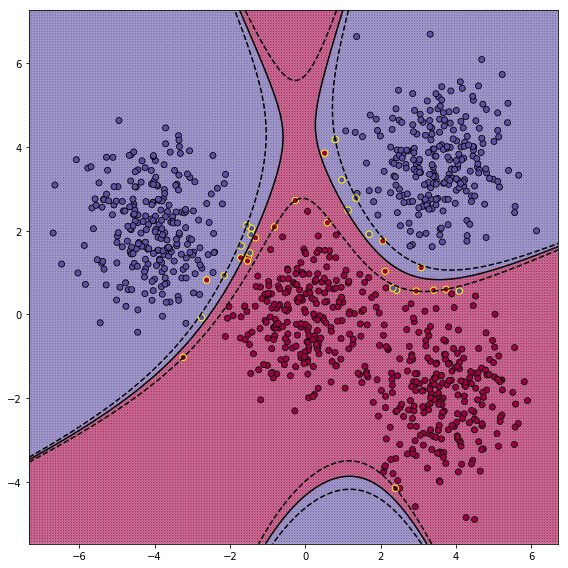

In [14]:
X, y = generate_dataset(False)
svm = KernelSVM(1, kernel=get_polynomial_kernel(1, 3))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

Реализация из sklearn

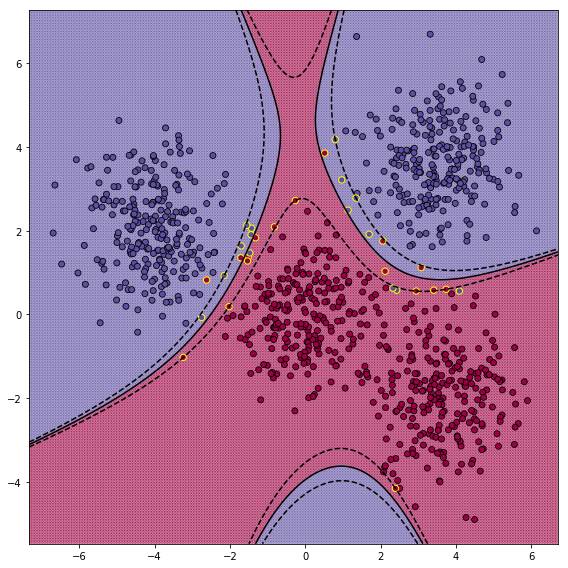

In [15]:
svm = OG(1, kernel="poly", degree=3, coef=1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

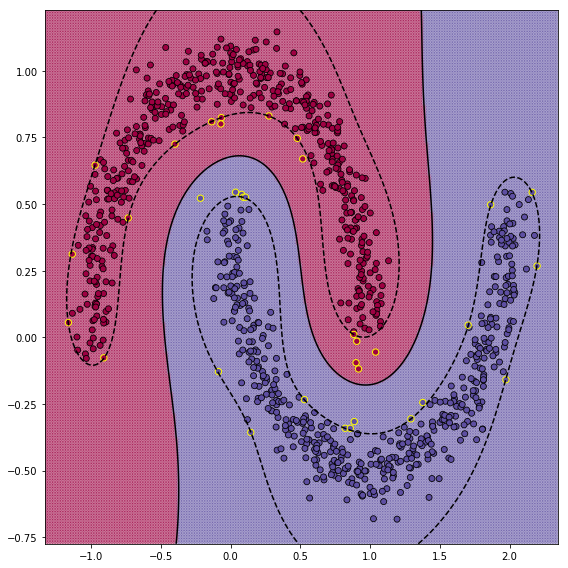

In [16]:
X, y = generate_dataset(True, 1000)
svm = KernelSVM(1, kernel=get_gaussian_kernel(0.4))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

Реализация из sklearn

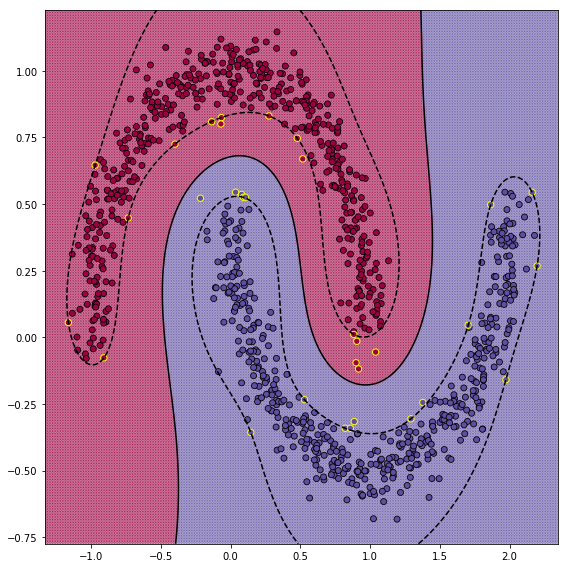

In [17]:
svm = OG(1, kernel="rbf", gamma=1/2/0.4/0.4)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

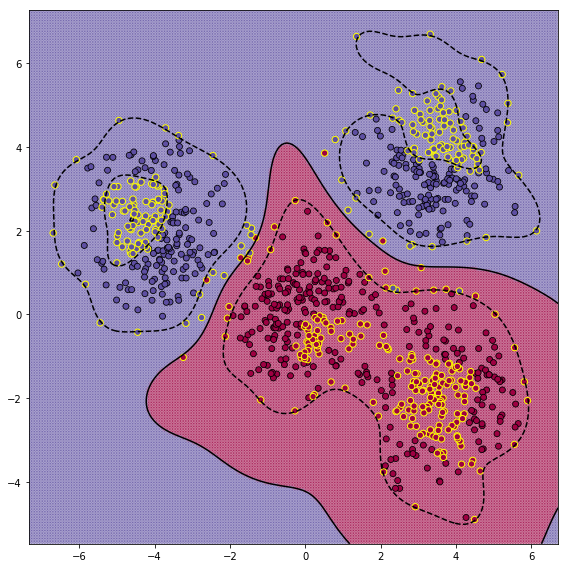

In [18]:
X, y = generate_dataset(False, 1000)
svm = KernelSVM(1, kernel=get_gaussian_kernel(0.9))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

Реализация из skelarn

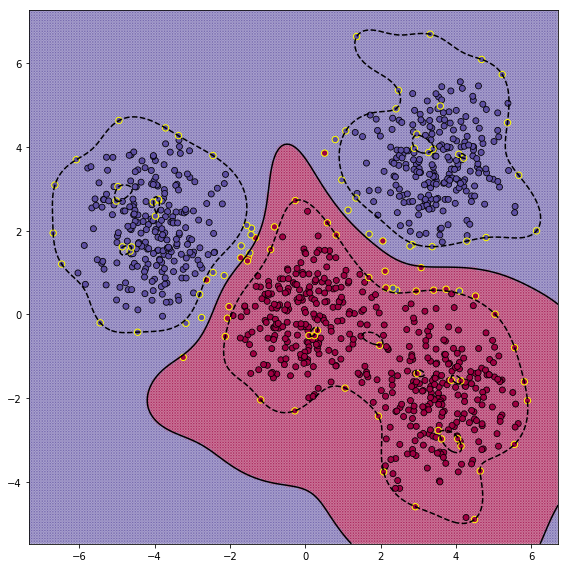

In [19]:
svm = OG(1, kernel="rbf", gamma=1/2/0.9/0.9)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

### Задание 4 (3 балла)
Исследуйте и опишите влияние параметров каждого вида ядра на полученный классификатор. Что происходит при увеличении константы в полиномиальном ядре? При увеличении степени? Как влияет на результат сигма в ядре Гаусса?

__При выполнении этого задания стоит написать код, который визуализирует классификаторы с различными ядрами__

Будем исследовать влияние параметров на количество опорных векторов (как минимум от этого зависит скорость всех операций в данной реализации) и на точность получившейся модели.

In [21]:
def get_accuracy(y_pred, y_true):
    return np.sum(y_pred==y_true) / len(y_true)

In [31]:
def plot(x, ys, ylabel, xlabel, legend=True):        
    plt.figure(figsize = (12, 3))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
#     plt.xlim(x[0], x[-1])
#     plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
#     for cls, cls_y in enumerate(ys):
    plt.plot(x, ys)
#     if legend:
#         plt.legend()
    plt.tight_layout()
    plt.show()

In [50]:
def test_gaussian(low=0.1, high=10, n=100):
    X_train, y_train = generate_dataset(False, 1000)
    X_test, y_test = generate_dataset(False, 1000)
    supp = np.zeros(n)
    accuracy = np.zeros(n)
    for i, sig in enumerate(np.linspace(low, high, n)):
        svm = KernelSVM(1, kernel=get_gaussian_kernel(sig))
        svm.fit(X_train, y_train)
        supp[i] = len(svm.support)
        accuracy[i] = get_accuracy(svm.predict(X_test), y_test)
        
    plot(np.linspace(low, high, n), supp, "#support vectors",  r"$\sigma$")
    plot(np.linspace(low, high, n), accuracy, "accuracy", r"$\sigma$")

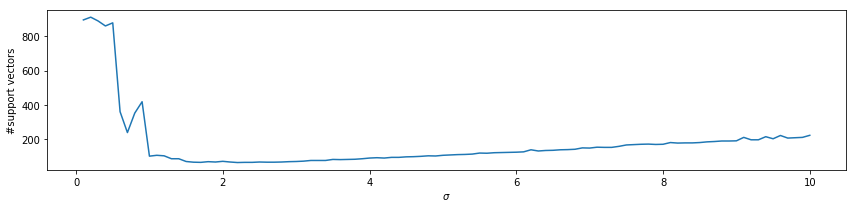

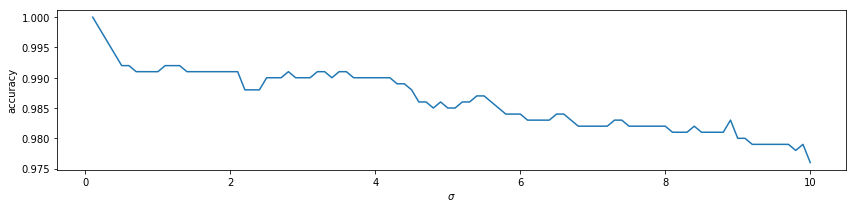

In [51]:
test_gaussian(low=0.1, high=10, n=100)

При увеличении дисперсии точность модели уменьшается. Количество опорных векторов сперва уменьшается до дисперсии около единицы, а потом медлено начинается увеличиваться, поэтому лучшие дисперсии будут в районе этого минимума, потому что векторов мало

In [82]:
def plot_poly(x, ys, degs, ylabel, xlabel, legend=True):        
    plt.figure(figsize = (12, 3))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for i, deg in enumerate(degs):
        plt.plot(x, ys[i], label="deg=" + str(deg))
    if legend:
        plt.legend()
    plt.tight_layout()
    plt.show()

In [83]:
def test_poly(degs, low = 0, high = 5, n=100):
    X_train, y_train = generate_dataset(False, 1000)
    X_test, y_test = generate_dataset(False, 1000)
    
    supps = []
    accuracies = []
    for deg in degs:
        supp = np.zeros(n)
        accuracy = np.zeros(n)
        for i, coef in enumerate(np.linspace(low, high, n)):
            svm = KernelSVM(1, kernel=get_polynomial_kernel(coef, deg))
            svm.fit(X_train, y_train)
            supp[i] = len(svm.support)
            accuracy[i] = get_accuracy(svm.predict(X_test), y_test)
        supps.append(supp)
        accuracies.append(accuracy)

    plot_poly(np.linspace(low, high, n), supps, degs, "#support vectors",  "coef")
    plot_poly(np.linspace(low, high, n), accuracies, degs, "accuracy", "coef")

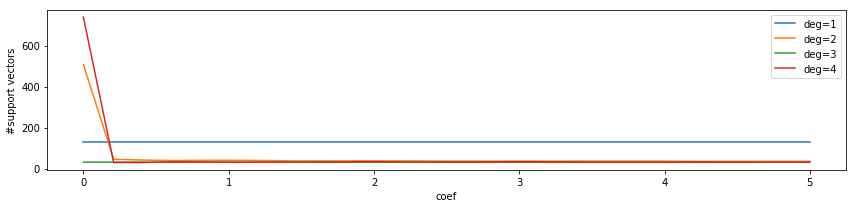

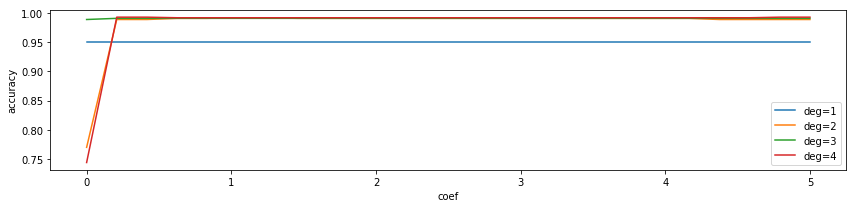

In [84]:
test_poly([1, 2, 3, 4], n=25)

По этим графикам видно, что при маллых константах и количество опорных векторов слишком большое и ошибка. Посмотрим подробнее на константы, где это не так.

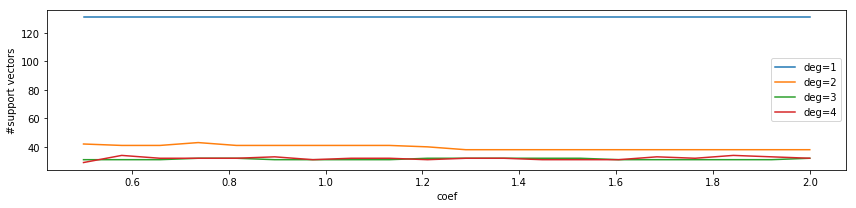

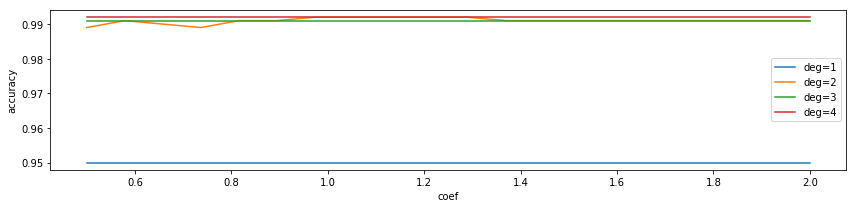

In [85]:
test_poly([1, 2, 3, 4], low=0.5, high=2, n=20)

Степень 1 проседает по всем параметрам. Нарисуем все без нее

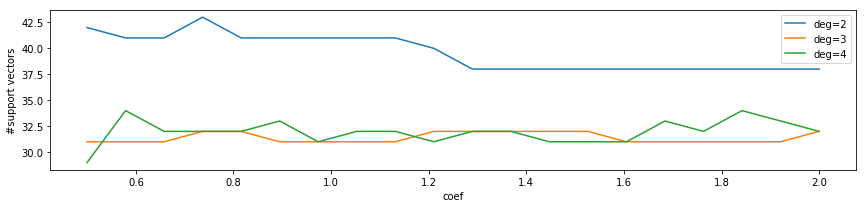

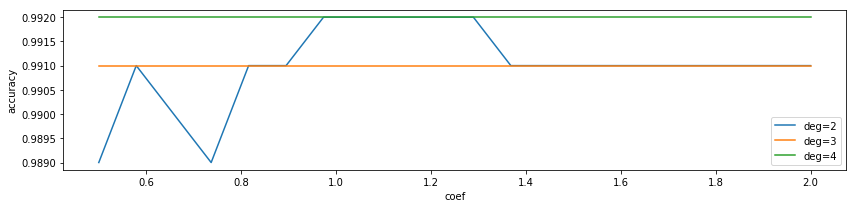

In [86]:
test_poly([2, 3, 4], low=0.5, high=2, n=20)

Большие степени дают немного лучший результат, а от констант ничего сильно не зависит

Дополнительно посмтроим еще интерактивные картины для разных ядер и датасетов (в гите не видны, нужно запускать ноутбук чтобы было видно)

In [87]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [92]:
X, y = generate_dataset(False, 1000)
def visualization_false_gaus(sigma):
    svm = KernelSVM(1, kernel=get_gaussian_kernel(sigma))
    svm.fit(X, y)
    visualize(svm, X, y)
    plt.show()

In [94]:
interact(visualization_false_gaus, sigma=(0.1, 4, 0.1))

interactive(children=(FloatSlider(value=2.0, description='sigma', max=4.0, min=0.1), Output()), _dom_classes=(…

<function __main__.visualization_false_gaus(sigma)>

In [95]:
X, y = generate_dataset(True, 1000)
def visualization_true_gaus(sigma):
    svm = KernelSVM(1, kernel=get_gaussian_kernel(sigma))
    svm.fit(X, y)
    visualize(svm, X, y)
    plt.show()

In [96]:
interact(visualization_true_gaus, sigma=(0.1, 4, 0.1))

interactive(children=(FloatSlider(value=2.0, description='sigma', max=4.0, min=0.1), Output()), _dom_classes=(…

<function __main__.visualization_true_gaus(sigma)>

In [97]:
X, y = generate_dataset(False, 1000)
def visualization_false_poly(coef, deg):
    svm = KernelSVM(1, kernel=get_polynomial_kernel(coef, deg))
    svm.fit(X, y)
    visualize(svm, X, y)
    plt.show()

In [99]:
interact(visualization_false_poly, coef=(0, 4, 0.4), deg=[1, 2, 3])

interactive(children=(FloatSlider(value=2.0, description='coef', max=4.0, step=0.4), Dropdown(description='deg…

<function __main__.visualization_false_poly(coef, deg)>

In [100]:
X, y = generate_dataset(True, 1000)
def visualization_true_poly(coef, deg):
    svm = KernelSVM(1, kernel=get_polynomial_kernel(coef, deg))
    svm.fit(X, y)
    visualize(svm, X, y)
    plt.show()

In [101]:
interact(visualization_true_poly, coef=(0, 4, 0.4), deg=[1, 2, 3])

interactive(children=(FloatSlider(value=2.0, description='coef', max=4.0, step=0.4), Dropdown(description='deg…

<function __main__.visualization_true_poly(coef, deg)>